# Linear boost adloc

Learning sparse linear map for each response: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1098.56it/s]


True H matrix:
[[1.  0.5 0.  0.  0.  0. ]
 [0.3 1.2 0.  0.  0.  0. ]
 [0.  0.  0.8 0.  0.  0. ]
 [0.  0.  0.  1.5 0.  0. ]]

Learned H matrix (dense):
[[0.9966637  0.4971366  0.         0.         0.         0.        ]
 [0.27967543 1.19863319 0.         0.         0.         0.        ]
 [0.         0.         0.77192108 0.         0.         0.        ]
 [0.         0.         0.         1.48667408 0.         0.        ]]

Correlation matrix:
[[ 0.86408144  0.36908443  0.1465945  -0.16181628 -0.02091388 -0.21341078]
 [ 0.09072502  0.9706872   0.00713049 -0.06504034  0.1560867  -0.15721428]
 [ 0.18228862 -0.02176664  0.99426864 -0.0233985  -0.09577642 -0.16715622]
 [-0.16566379 -0.01325692  0.01046506  0.99733761  0.20231228  0.06672459]]

Correlation sparsity pattern (threshold = 0.3):
[[1 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]]

Regression sparsity pattern:
[[1 1 0 0 0 0]
 [1 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]]

True sparsity pattern:
[[1 1 0 0 0 0]
 [1 1 0 0 

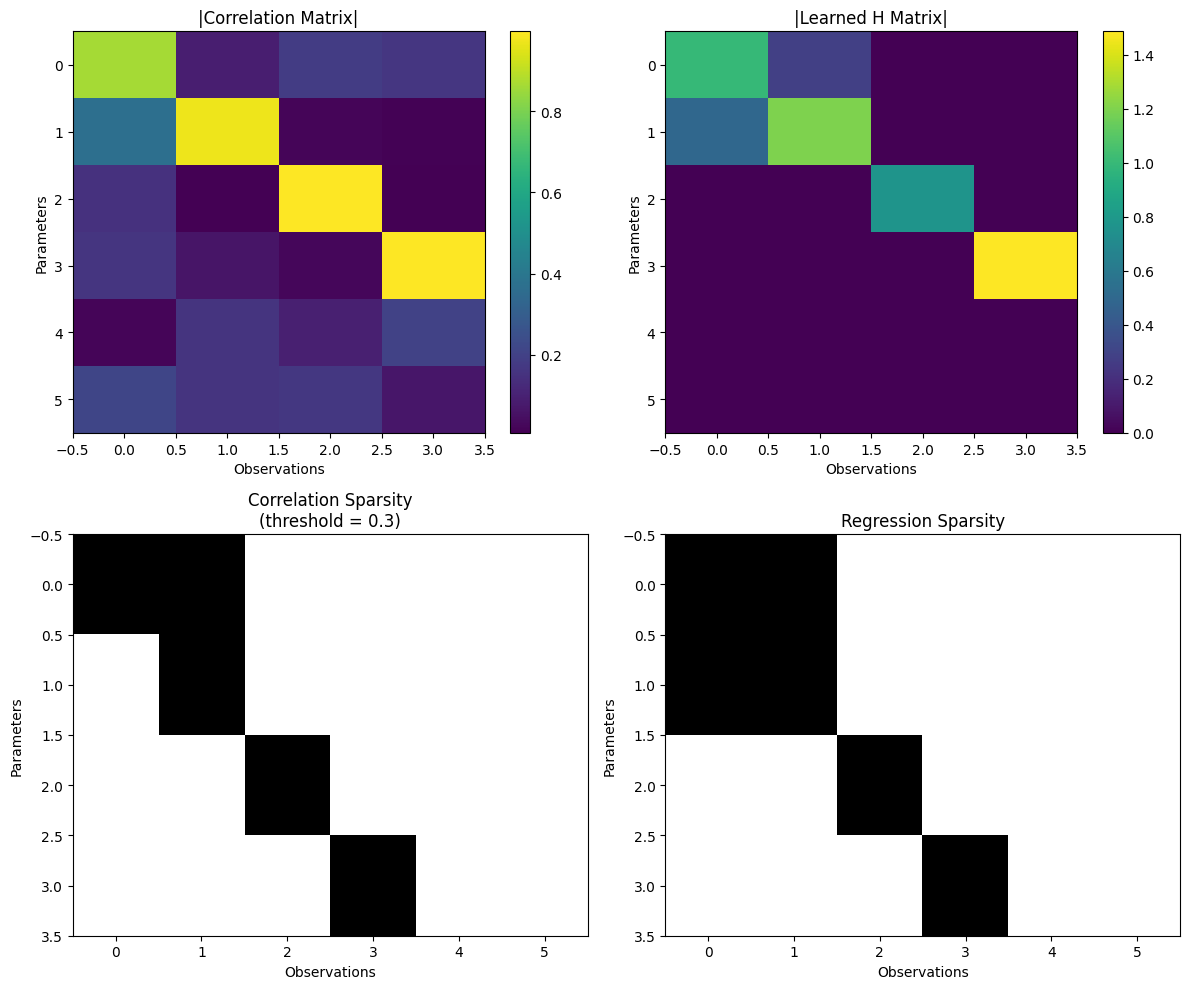

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from graphite_maps.linear_regression import linear_boost_ic_regression

# Create synthetic data
np.random.seed(42)
n_params = 6
n_obs = 4
ensemble_size = 100

# Create block-diagonal structure
# Parameters 0,1 only affect observations 0,1
# Parameters 2,3 only affect observations 2,3
# Parameters 4,5 don't affect any observations (noise only)

X = np.random.randn(n_params, ensemble_size)

# Define true linear relationships (num_obs x num_params)
H_true = np.array(
    [
        [1.0, 0.5, 0.0, 0.0, 0.0, 0.0],  # obs 0 depends on params 0,1
        [0.3, 1.2, 0.0, 0.0, 0.0, 0.0],  # obs 1 depends on params 0,1
        [0.0, 0.0, 0.8, 0.0, 0.0, 0.0],  # obs 2 depends on param 2
        [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],  # obs 3 depends on param 3
    ]
)

# Generate observations with some noise
Y = H_true @ X + 0.1 * np.random.randn(n_obs, ensemble_size)


# Method 1: Correlation-based sparsity
def empirical_cross_covariance(A, B):
    """Compute empirical cross-covariance between A and B"""
    A_centered = A - np.mean(A, axis=1, keepdims=True)
    B_centered = B - np.mean(B, axis=1, keepdims=True)
    return A_centered @ B_centered.T / (A.shape[1] - 1)


cov_XY = empirical_cross_covariance(X, Y)
stds_X = np.std(X, axis=1, ddof=1)
stds_Y = np.std(Y, axis=1, ddof=1)
corr_XY = cov_XY / (stds_X[:, np.newaxis] * stds_Y[np.newaxis, :])

threshold = 3 / np.sqrt(ensemble_size)
correlation_sparsity = (np.abs(corr_XY) > threshold).T

# Method 2: Regression-based sparsity using linear_boost_ic_regression
# Note: linear_boost_ic_regression expects U=X.T, Y=Y.T
# It learns Y.T ≈ X.T @ H, so H should be (n_params, n_obs)
H_sparse = linear_boost_ic_regression(U=X.T, Y=Y.T)

# Convert sparse matrix to dense for visualization
H_dense = H_sparse.toarray()
regression_sparsity = H_dense != 0

print("True H matrix:")
print(H_true)
print("\nLearned H matrix (dense):")
print(H_dense)

# Note that it misses the correlation between obs 1 and param 0,
# because the relation between them in `H_true` is weak (0.3).
# Weak true relationships can fall below statistical detection thresholds
# in correlation-based methods, while regression methods with proper
# regularization can still detect them as meaningful contributors to the model.
print("\nCorrelation matrix:")
print(corr_XY.T)
print(f"\nCorrelation sparsity pattern (threshold = {threshold}):")
print(correlation_sparsity.astype(int))

print("\nRegression sparsity pattern:")
print(regression_sparsity.astype(int))

print("\nTrue sparsity pattern:")
true_sparsity = (np.abs(H_true) > 0).astype(int)
print(true_sparsity)

# Check if patterns match
corr_matches_true = np.array_equal(correlation_sparsity, np.abs(H_true) > 0)
reg_matches_true = np.array_equal(regression_sparsity, np.abs(H_true) > 0)

print("\nPattern matching results:")
print(f"Correlation method matches true pattern: {corr_matches_true}")
print(f"Regression method matches true pattern: {reg_matches_true}")

# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Correlation matrix
im1 = axes[0, 0].imshow(np.abs(corr_XY), cmap="viridis", aspect="auto")
axes[0, 0].set_title("|Correlation Matrix|")
axes[0, 0].set_xlabel("Observations")
axes[0, 0].set_ylabel("Parameters")
plt.colorbar(im1, ax=axes[0, 0])

# Plot 2: Learned H matrix
im2 = axes[0, 1].imshow(np.abs(H_dense.T), cmap="viridis", aspect="auto")
axes[0, 1].set_title("|Learned H Matrix|")
axes[0, 1].set_xlabel("Observations")
axes[0, 1].set_ylabel("Parameters")
plt.colorbar(im2, ax=axes[0, 1])

# Plot 3: Correlation sparsity pattern
axes[1, 0].imshow(correlation_sparsity, cmap="gray_r", aspect="auto")
axes[1, 0].set_title(f"Correlation Sparsity\n(threshold = {threshold})")
axes[1, 0].set_xlabel("Observations")
axes[1, 0].set_ylabel("Parameters")

# Plot 4: Regression sparsity pattern
axes[1, 1].imshow(regression_sparsity, cmap="gray_r", aspect="auto")
axes[1, 1].set_title("Regression Sparsity")
axes[1, 1].set_xlabel("Observations")
axes[1, 1].set_ylabel("Parameters")

plt.tight_layout()